In [213]:
!mkdir ../dataset 
!mkdir models
!wget -O ../dataset/KDDTrain+_20Percent.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B_20Percent.txt
!wget -O ../dataset/KDDTrain+.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B.txt
!wget -O ../dataset/KDDTest+.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest%2B.txt
!wget -nv -O models/cnn1_4.pt https://github.com/acen20/DEL/raw/master/deep-ensemble-jet/models/cnn1_4.pt
!wget -nv -O models/cnn2_5.pt https://github.com/acen20/DEL/raw/master/deep-ensemble-jet/models/cnn2_5.pt
!wget -nv -O models/sparse_encoder.pt https://github.com/acen20/DEL/raw/master/deep-ensemble-jet/models/sparse_encoder.pt

mkdir: cannot create directory ‘../dataset’: File exists
mkdir: cannot create directory ‘models’: File exists
--2022-03-05 07:36:41--  https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B_20Percent.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3822033 (3.6M) [text/plain]
Saving to: ‘../dataset/KDDTrain+_20Percent.txt’

../dataset/KDDTrain 100%[===================>]   3.64M  --.-KB/s    in 0.07s   

2022-03-05 07:36:41 (49.9 MB/s) - ‘../dataset/KDDTrain+_20Percent.txt’ saved [3822033/3822033]

--2022-03-05 07:36:41--  https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199

In [214]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

In [215]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [216]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Loading Dataset
# Dataset link: https://data.mendeley.com/datasets/xvyv59vwvz/1
# Dataset is present in the current directory containing the code file.
df=pd.read_csv('../dataset/KDDTrain+.txt', header=None)
df2=pd.read_csv('../dataset/KDDTest+.txt', header=None)

## Preprocessing

In [217]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [218]:
df.columns = [str(i) for i in range(0, len(df.columns))]
df2.columns = [str(i) for i in range(0, len(df2.columns))]

In [219]:
# Replacing Null values with 0. ML classifer cannot learn on Null values
df.fillna(0, inplace=True)
df2.fillna(0, inplace=True)

In [220]:
# Peak on dataset
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [221]:
df.shape

(125973, 43)

In [222]:
# Peak on the dataset
df.drop('42',axis=1, inplace=True)
df2.drop('42',axis=1, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [223]:
sub_classes = df.iloc[:,41].value_counts()

In [224]:
print(sub_classes)

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: 41, dtype: int64


In [225]:
r2l = ['ftp_write','guess_passwd', 'imap', 'multihop', 'phf', 'spy','warezclient','warezmaster','xlock', 'xsnoop','named',
       'sendmail','snmpgetattack', 'snmpguess','httptunnel']
u2r = ['buffer_overflow', 'loadmodule','perl','ps','rootkit','sqlattack','xterm']
dos = ['back', 'land', 'neptune', 'smurf', 'teardrop','pod','mailbomb', 'processtable','udpstorm', 'worm','apache2']
probe = ['ipsweep', 'nmap', 'portsweep', 'satan','saint','mscan']

In [226]:
df['41'] = df['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else x
    )

df2['41'] = df2['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else x
    )

### Training set value counts

In [227]:
print(df['41'].value_counts())

normal       67343
malicious    58630
Name: 41, dtype: int64


### Testing set value counts

In [228]:
print(df2['41'].value_counts())

malicious    12833
normal        9711
Name: 41, dtype: int64


In [229]:
# Encodings Labels so that they are compatible with machine leanring classifiers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for i in df:
    if df[i].dtype=='object':
        df[i] = le.fit_transform(df[i])
    else:
        continue
for i in df2:
    if df2[i].dtype=='object':
        df2[i] = le.fit_transform(df2[i])
    else:
        continue
        
X_train = df.drop(['41'],axis=1)
y_train = df['41']

X_test = df2.drop(['41'],axis=1)
y_test = df2['41']

In [230]:
# Scaling data. Default scaling is to scale the data to unit variance (or equivalent
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_train = torch.tensor(X_train, dtype=torch.float)

X_test = mms.fit_transform(X_test)
X_test = torch.tensor(X_test, dtype=torch.float)

## **CNN 1**



In [254]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
current_dims = 41

In [232]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1,3,kernel_size = (1,4), stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.Conv1d(3,3,kernel_size = (1,4), stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.Conv1d(3,3,kernel_size = (1,4), stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.Flatten(),
            nn.Linear(96, 32),
            nn.ReLU()
        )

        self.clf = nn.Sequential(
            nn.Linear(32,2),
        )

    def forward(self, x):
        features = self.cnn(x)
        return self.clf(features)

    def transform(self, x):
        return self.cnn(x)

## **CNN 2**

In [233]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.cnn = nn.Sequential(
          nn.Conv1d(1,3,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(3),
          nn.Conv1d(3,3,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(3),
          nn.Conv1d(3,3,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(3),
          nn.Conv1d(3,3,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(3),
          nn.Flatten(),
          nn.Linear(99, 41),
          nn.ReLU()
        )

        self.clf = nn.Sequential(
            nn.Linear(41,5),
        )

    def forward(self, x):
        features = self.cnn(x)
        return self.clf(features)

    def transform(self, x):
        return self.cnn(x)

## **Sparse AE**

In [234]:
class SparseEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(current_dims, current_dims),
        nn.BatchNorm1d(current_dims),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(current_dims,current_dims ),
        nn.BatchNorm1d(current_dims),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(current_dims, current_dims),
        nn.BatchNorm1d(current_dims),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(current_dims, current_dims),
        nn.BatchNorm1d(current_dims),
        nn.ReLU(),
    )

  def forward(self, x):
    encoded = self.encoder(x)
    return encoded

In [255]:
cnn1 = CNN1()
cnn1.load_state_dict(torch.load('models/cnn1_4.pt'))
cnn1.eval()
with torch.no_grad():
  f1 = cnn1.transform(X_train.view(-1,1,1,41))
  f1_test = cnn1.transform(X_test.view(-1,1,1,41))

cnn2 = CNN2()
cnn2.load_state_dict(torch.load('models/cnn2_5.pt'))
cnn2.eval()
with torch.no_grad():
  f2 = cnn2.transform(X_train.view(-1,1,1,41))
  f2_test = cnn2.transform(X_test.view(-1,1,1,41))

sparse_ae = SparseEncoder()
sparse_ae.load_state_dict(torch.load('models/sparse_encoder.pt'))
sparse_ae.eval()
with torch.no_grad():
  f3 = sparse_ae(X_train)
  f3_test = sparse_ae(X_test)

In [256]:
new_features = torch.cat((f1,f2,f3),dim = 1)
new_features_test = torch.cat((f1_test,f2_test,f3_test),dim = 1)
print(new_features.shape)
print(new_features_test.shape)

torch.Size([125973, 114])
torch.Size([22544, 114])


In [237]:
current_dims = new_features.shape[1]
encoded_dims = 41

In [239]:
pt_train = TensorDataset(new_features, torch.tensor(y_train))
pt_train = DataLoader(pt_train, batch_size=64)

In [240]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(current_dims, current_dims*2),
        nn.BatchNorm1d(current_dims*2),
        nn.LeakyReLU(),
        nn.Linear(current_dims*2, current_dims),
        nn.BatchNorm1d(current_dims),
        nn.LeakyReLU(),
        nn.Linear(current_dims,encoded_dims),
    )

  def forward(self, x):
    encoded = self.encoder(x)
    return encoded

In [241]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.decoder = nn.Sequential(
        nn.Linear(encoded_dims, current_dims),
        nn.BatchNorm1d(current_dims),
        nn.LeakyReLU(),
        nn.Linear(current_dims, current_dims*2),
        nn.BatchNorm1d(current_dims*2),
        nn.LeakyReLU(),
        nn.Linear(current_dims*2,current_dims),
    )

  def forward(self, x):
    decoded = self.decoder(x)
    return decoded

In [242]:
encoder = Encoder()
decoder = Decoder()
parameters = list(encoder.parameters())+ list(decoder.parameters())
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr = 4e-3)

In [243]:
new_features.shape, y_train.shape

(torch.Size([125973, 114]), (125973,))

In [244]:
num_epochs = 50
outputs = []
losses = []
for epoch in range(num_epochs):
  for instance,_ in pt_train:
    encoded = encoder(instance)
    reconstructed = decoder(encoded)
    loss = criterion(reconstructed, instance)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  losses.append(loss.item())
  print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')

Epoch:1, Loss:0.1686
Epoch:2, Loss:0.1491
Epoch:3, Loss:0.1403
Epoch:4, Loss:0.1355
Epoch:5, Loss:0.1302
Epoch:6, Loss:0.1227
Epoch:7, Loss:0.1133
Epoch:8, Loss:0.0994
Epoch:9, Loss:0.0935
Epoch:10, Loss:0.0884
Epoch:11, Loss:0.0836
Epoch:12, Loss:0.0815
Epoch:13, Loss:0.0798
Epoch:14, Loss:0.0765
Epoch:15, Loss:0.0756
Epoch:16, Loss:0.0726
Epoch:17, Loss:0.0710
Epoch:18, Loss:0.0697
Epoch:19, Loss:0.0681
Epoch:20, Loss:0.0667
Epoch:21, Loss:0.0648
Epoch:22, Loss:0.0644
Epoch:23, Loss:0.0642
Epoch:24, Loss:0.0639
Epoch:25, Loss:0.0618
Epoch:26, Loss:0.0618
Epoch:27, Loss:0.0623
Epoch:28, Loss:0.0611
Epoch:29, Loss:0.0606
Epoch:30, Loss:0.0598
Epoch:31, Loss:0.0585
Epoch:32, Loss:0.0582
Epoch:33, Loss:0.0579
Epoch:34, Loss:0.0576
Epoch:35, Loss:0.0569
Epoch:36, Loss:0.0562
Epoch:37, Loss:0.0559
Epoch:38, Loss:0.0552
Epoch:39, Loss:0.0544
Epoch:40, Loss:0.0538
Epoch:41, Loss:0.0533
Epoch:42, Loss:0.0519
Epoch:43, Loss:0.0522
Epoch:44, Loss:0.0520
Epoch:45, Loss:0.0516
Epoch:46, Loss:0.05

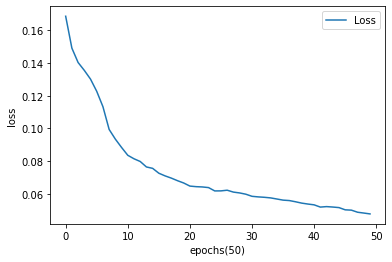

In [245]:
plt.plot(losses)
plt.xlabel(f"epochs({num_epochs})")
plt.ylabel(f"loss")
_ = plt.legend(['Loss'])

In [257]:
encoder.eval()
with torch.no_grad():
  train_X = encoder(new_features.to(device)).cpu()
  X_test = encoder(new_features_test.to(device)).cpu()

In [258]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam',hidden_layer_sizes=(5,10), random_state=1)
clf.fit(train_X, y_train)

MLPClassifier(hidden_layer_sizes=(5, 10), random_state=1)

In [259]:
y_pred = clf.predict(X_test)

0.7584279630943932
Test accuracy is:0.7584
Precision: 0.9787 Recall: 0.6446


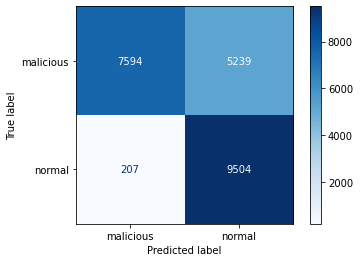

In [260]:
acc = accuracy_score(y_pred, y_test)
print(acc)
_ = ConfusionMatrixDisplay.from_predictions(y_test,y_pred, cmap="Blues", display_labels = le.classes_)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
tn=cm[0][0] #tn
fn=cm[0][1] #fn
fp=cm[1][0] #fp
tp=cm[1][1] #tp
acc= (tp+tn)/(tp+tn+fn+fp)
epsilon = 1e-7 # is used so that to avoid divide by zero error
precision = tp / (tp + fp + epsilon)
recall = tp / (tp + fn + epsilon)
sensitivity,specificity = tp/(tp+fn),tn/(tn+fp)
print("Test accuracy is:"+str(format(acc,'.4f')))
print("Precision: "+str(format(precision,'.4f'))+" Recall: "+str(format(recall,'.4f')))

In [261]:
le.inverse_transform([i for i in range(0,2)])

array(['malicious', 'normal'], dtype=object)

In [262]:
torch.save(encoder.state_dict(), 'nlpca.pt')